## Transformações dos dados (colocar dentro da pipeline)

In [120]:
import sys
import os
import pandas as pd
import numpy as np
import warnings
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split,StratifiedKFold,GridSearchCV,cross_val_score
from sklearn.ensemble import RandomForestClassifier
from scipy.stats import ks_2samp,chi2_contingency
warnings.filterwarnings('ignore')
from sklearn.preprocessing import OneHotEncoder, StandardScaler,FunctionTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer, make_column_selector as selector
from sklearn.neighbors import KNeighborsClassifier
sys.path.append(r"C:\Users\edude\OneDrive\Área de Trabalho\Códigos\Faculdade\6_Periodo\Aprendizado_superv\Trabalho_aprendizado_super")
from utils.classes import FeatureBuilder
from sklearn.metrics import accuracy_score,roc_auc_score,confusion_matrix,classification_report,RocCurveDisplay

In [129]:
dados = pd.read_csv(r'C:\Users\edude\OneDrive\Área de Trabalho\Códigos\Faculdade\6_Periodo\Aprendizado_superv\Trabalho_aprendizado_super\data\gold\dados_finais_gold.csv')

### Etapas:

- Separação treino e teste
    - Validação da separação dos dados

- Pipeline de transformação e criação de variaveis

- Modelos 

- Avaliação dos modelos

- Estudos de threshold 

- Feature importance, outras análises

#### Transformações necessárias

In [130]:
dados = dados[dados['age']<=100]
dados['became_member_on'] = pd.to_datetime(dados['became_member_on'],errors='coerce')
dados['month'] = dados['became_member_on'].dt.month
dados = dados.drop(columns={'valor_total','valor_total_log'})

#### Treino e Teste

In [132]:
x = dados.drop(columns=['responded'])
y = dados['responded']

x_train, x_test, y_train, y_test = train_test_split(
    x, y, test_size=0.2, random_state=42, stratify=y)

In [133]:
num_cols = x_train.select_dtypes(include=[np.number]).columns

resultados_num = []
for col in num_cols:
    stat, p = ks_2samp(x_train[col], x_test[col])
    resultados_num.append({"variavel": col,"media_train": x_train[col].mean(),"media_test": x_test[col].mean(),"p_ks": p})
    
resultados_num = pd.DataFrame(resultados_num).sort_values("p_ks")

resultados_num

,variavel,media_train,media_test,p_ks
0,age,54.388968,54.117924,0.116141
9,time_total,399.756946,401.467983,0.462115
1,income,65392.908090,65365.546599,0.585306
10,month,6.677853,6.706548,0.758253
3,difficulty,7.737156,7.645231,0.839510
6,mobile,0.897720,0.903179,0.953651
4,duration,6.512805,6.489539,0.973721
8,web,0.798383,0.803007,0.991194
2,reward_offer,4.203813,4.211937,1.000000
5,email,1.000000,1.000000,1.000000


<Figure size 600x400 with 0 Axes>

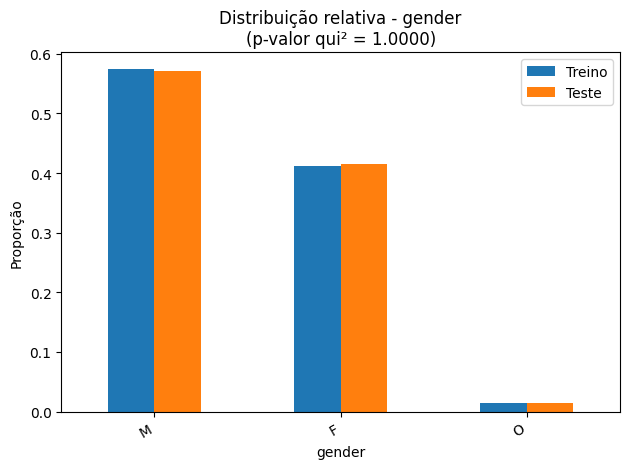

<Figure size 600x400 with 0 Axes>

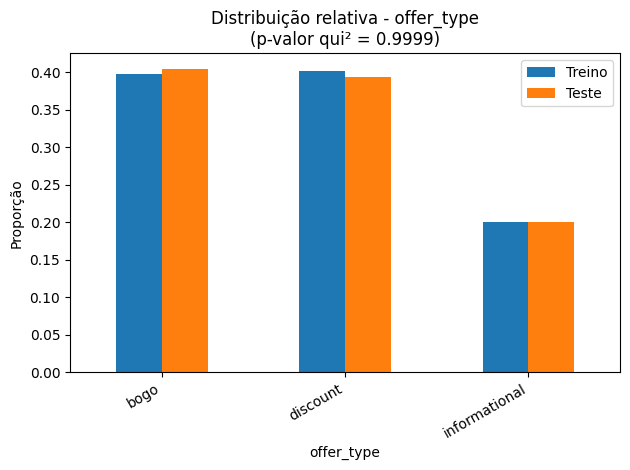

,variavel,p_chi2
1,offer_type,0.999930
0,gender,0.999968


In [134]:
cat_cols = x_train.select_dtypes(exclude=[np.number]).columns
cat_cols = cat_cols.drop(['offer_id','person','became_member_on'], errors='ignore') 
resultados_cat = []
for col in cat_cols:
    tabela = pd.crosstab(x_train[col], x_test[col])
    dist_train = x_train[col].value_counts(normalize=True)
    dist_test = x_test[col].value_counts(normalize=True)
    all_idx = dist_train.index.union(dist_test.index)
    dist_train = dist_train.reindex(all_idx, fill_value=0)
    dist_test = dist_test.reindex(all_idx, fill_value=0)
    chi2, p, dof, _ = chi2_contingency([dist_train, dist_test])
    resultados_cat.append({
        "variavel": col,
        "p_chi2": p
    })

    plt.figure(figsize=(6,4))
    df_plot = pd.DataFrame({
        "Treino": dist_train,
        "Teste": dist_test
    })
    df_plot.plot(kind="bar")
    plt.title(f"Distribuição relativa - {col}\n(p-valor qui² = {p:.4f})")
    plt.ylabel("Proporção")
    plt.xticks(rotation=30, ha="right")
    plt.tight_layout()
    plt.show()


resultados_cat = pd.DataFrame(resultados_cat).sort_values("p_chi2")
resultados_cat


In [135]:
dados_id = ['person', 'offer_id']

feature_pipeline = Pipeline( steps=[
    ('feature_engineering', FeatureBuilder(map_gender=True, drop_raw=True))
])

numeric_transformer = Pipeline(steps=[
    ('inputer_num', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())
])

categorical_transformer = Pipeline(steps=[
    ('inputer_cat', SimpleImputer(strategy='constant', fill_value='missing')),
    ('enconder', OneHotEncoder(handle_unknown='ignore', sparse_output=False))
])

num_sel = lambda X: X.select_dtypes(include=['number']).columns.difference(dados_id)
cat_sel = lambda X: X.select_dtypes(exclude=['number']).columns.difference(dados_id)


preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, num_sel),
        ('cat', categorical_transformer, cat_sel),
        ('drop_ids', 'drop', dados_id)
    ],
    remainder='drop'
)

prep_pipe = Pipeline(steps=[
    ('fe', feature_pipeline),
    ('pre', preprocessor)
])

model_base_knn = KNeighborsClassifier(n_neighbors=3)
model_base_clf = RandomForestClassifier(random_state=42)


pipe_model = Pipeline(steps=[
    ('prep',prep_pipe),
    ('model', model_base_clf)
])

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

scores = cross_val_score(
    pipe_model,
    x_train,
    y_train,
    cv=cv,
    scoring='roc_auc'
)

print("Scores por fold:", scores)
print("Média:", scores.mean())
print("Desvio padrão:", scores.std())


Scores por fold: [0.83518329 0.84013619 0.84798907 0.8409406  0.83407085]
Média: 0.8396639998877555
Desvio padrão: 0.004950141803542301


In [116]:
pipe_model.fit(x_train, y_train)


,steps,"[('prep', ...), ('model', ...)]"
,transform_input,None
,memory,None
,verbose,False
,steps,"[('fe', ...), ('pre', ...)]"
,transform_input,None
,memory,None
,verbose,False
,steps,"[('feature_engineering', ...)]"
,transform_input,None
,memory,None


In [117]:
y_pred = pipe_model.predict(x_test)


In [118]:
y_proba = pipe_model.predict_proba(x_test)[:, 1]


In [119]:
print("Acurácia:", accuracy_score(y_test, y_pred))
print("ROC AUC:", roc_auc_score(y_test, y_proba))

print("\nMatriz de Confusão:\n", confusion_matrix(y_test, y_pred))
print("\nRelatório de Classificação:\n", classification_report(y_test, y_pred))

Acurácia: 0.9892219907617064
ROC AUC: 0.9968714042217419

Matriz de Confusão:
 [[5392   62]
 [  57 5530]]

Relatório de Classificação:
               precision    recall  f1-score   support

         0.0       0.99      0.99      0.99      5454
         1.0       0.99      0.99      0.99      5587

    accuracy                           0.99     11041
   macro avg       0.99      0.99      0.99     11041
weighted avg       0.99      0.99      0.99     11041



## Rascunho

In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import cross_val_score, StratifiedKFold
from sklearn.ensemble import RandomForestClassifier

# ============================================================
# 1) Preparar variável-alvo (exemplo: se cliente completou uma oferta)
# ------------------------------------------------------------
# Vamos criar uma variável binária: 1 se houve pelo menos um "offer_completed",
# 0 caso contrário.
clientes_completaram = master.groupby("person")['event'].apply(
    lambda x: int('offer_completed' in x.values)
).reset_index().rename(columns={'event':'completed_offer'})

# Junta essa informação com perfil (onde está o 'income')
df_model = clientes_completaram.merge(df_profile_clean, left_on="person", right_on="id", how="left")

# ============================================================
# 2) Duas versões do dataset
# ------------------------------------------------------------
# a) Versão sem imputação (descarta missing em income)
df_sem_imputacao = df_model.dropna(subset=['income']).copy()

# b) Versão com imputação (substitui missing em income pela mediana)
df_com_imputacao = df_model.copy()
mediana_income = df_com_imputacao['income'].median()
df_com_imputacao['income'] = df_com_imputacao['income'].fillna(mediana_income)

# ============================================================
# 3) Definir X (features) e y (target)
# ------------------------------------------------------------
features = ['age', 'income']   # podemos usar outras, mas income é o foco
target = 'completed_offer'

X1, y1 = df_sem_imputacao[features], df_sem_imputacao[target]
X2, y2 = df_com_imputacao[features], df_com_imputacao[target]

# ============================================================
# 4) Classificador e Validação Cruzada
# ------------------------------------------------------------
clf = RandomForestClassifier(random_state=42)

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Sem imputação
scores_sem = cross_val_score(clf, X1, y1, cv=cv, scoring='accuracy')

# Com imputação
scores_com = cross_val_score(clf, X2, y2, cv=cv, scoring='accuracy')

# ============================================================
# 5) Resultados
# ------------------------------------------------------------
print("Validação Cruzada (sem imputação):")
print("Acurácias:", scores_sem)
print("Média:", scores_sem.mean())

print("\nValidação Cruzada (com imputação pela mediana):")
print("Acurácias:", scores_com)
print("Média:", scores_com.mean())


Validação Cruzada (sem imputação):
Acurácias: [0.75143339 0.75177066 0.75379427 0.753457   0.75143339]
Média: 0.7523777403035413

Validação Cruzada (com imputação pela mediana):
Acurácias: [0.74911765 0.73794118 0.73470588 0.74029412 0.73764706]
Média: 0.7399411764705882


<!-- # Validação Cruzada — Imputação de Renda (income)

## O que foi feito

1) **Definimos a variável-alvo (target)**  
   - Para cada cliente (`person`), marcamos `1` se ele **completou ao menos uma oferta** (`offer_completed`) e `0` caso contrário.  
   - Isso transforma o problema em **classificação binária** (completou vs. não completou).

2) **Juntamos o alvo com o perfil do cliente**  
   - Cruzamos com `df_profile_clean` para ter as features **`age`** e **`income`** (renda).

3) **Criamos duas versões do dataset** para testar o *tratamento de valores ausentes*:
   - **Sem imputação**: removemos linhas onde `income` era nulo (`NaN`).  
   - **Com imputação**: preenchemos `income` faltante com a **mediana** da renda.

4) **Treinamos e avaliamos um modelo igual nos dois cenários**  
   - Modelo: **RandomForestClassifier** (padrão, `random_state=42`).  
   - Validação: **5-fold Stratified Cross-Validation** (mantém a proporção de classes em cada dobra).  
   - Métrica: **accuracy** (acertos/total) em cada dobra; depois calculamos a **média**.

---

## Resultados

- **Sem imputação (descartando NaN)**  
  Acurácias por dobra: `[0.7514, 0.7518, 0.7538, 0.7535, 0.7514]`  
  **Média:** **0.7524**

- **Com imputação (mediana)**  
  Acurácias por dobra: `[0.7491, 0.7379, 0.7347, 0.7403, 0.7376]`  
  **Média:** **0.7399**

---

- A **validação cruzada** estima o desempenho **fora da amostra** (generalização) e reduz o risco de avaliar o modelo apenas em um único “corte” dos dados.
- O modelo **sem imputação** teve **accuracy médio ~1,25 p.p. maior** (*0,7524 vs 0,7399*).  
- Como o **modelo** e a **validação** foram idênticos nos dois cenários, a diferença se deve ao **tratamento de valores ausentes em `income`**.

---

## Conclusão 

- **Para este alvo e esse conjunto de features**, **descartar** as linhas sem `income` rendeu melhor desempenho do que **imputar por mediana**.  
- Possíveis razões:
  - As ausências de `income` **não são aleatórias** (o que a mediana não captura), introduzindo ruído.  
  - Preencher com um valor “típico” (mediana) **achata diferenças** entre clientes e reduz o sinal preditivo.

**Decisão prática:** para esta tarefa, **manter a versão sem imputação de `income`** foi **ligeiramente melhor**.  
(Anote no relatório que você testou os dois tratamentos e comparou com validação cruzada.)

--- -->

